# view 1t and 5 kt coeff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tables
import h5py
import os, sys
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
pdf = PdfPages('peTimeCoeff.pdf')

# 1t coeff
#### pe

In [3]:
# fit odd order, even order is 0
def odd_func(x, a, b, c, d, e):
    return a * x**1 + b * x**3 + c * x**5 + d * x**7 + e * x**9
# fit even order, even order is 0
def even_func(x, a, b, c, d, e):
    return a * x**0 + b * x**2 + c * x**4 + d * x**6 + e * x**8
# load data
def LoadDataPE(path, radius, order):
    data = []
    filename = path + 'file_' + radius + '.h5'
    h = tables.open_file(filename,'r')

    coeff = 'coeff' + str(order)
    mean = 'mean' + str(order)
    predict = 'predict' +str(order)
    rate = 'rate' + str(order)
    hinv = 'hinv' + str(order)
    chi = 'chi' + str(order)
    
    a = eval('np.array(h.root.'+ coeff + '[:])')
    b = eval('np.array(h.root.'+ mean + '[:])')
    c = eval('np.array(h.root.'+ predict + '[:])')
    try:
        d = eval('h.root.'+ rate + '[:])')
    except:
        d = np.array(0)
    e = eval('np.array(h.root.'+ hinv + '[:])')
    f = eval('np.array(h.root.'+ chi + '[:])')
    
    data.append(np.array(np.array((a,b,c,d,e,f))))
    return data


def LoadFileTime(path, radius, order):
    data = []
    filename = path + 'file_' + radius + '.h5'
    h = tables.open_file(filename,'r')

    coeff = 'coeff' + str(order)
    
    a = eval('np.array(h.root.'+ coeff + '[:])')

    data.append(np.array((np.array(a))))
    return data

In [9]:
np.arange(10000, -10000, -1000)

array([10000,  9000,  8000,  7000,  6000,  5000,  4000,  3000,  2000,
        1000,     0, -1000, -2000, -3000, -4000, -5000, -6000, -7000,
       -8000, -9000])

In [4]:
## gather the data
path = '../coeff_pe_1t_339MeV/'
#ra = np.arange(+0.651, -0.65, -0.01)
ra = np.arange(10000, -10000, -1000)

order = 10
coeff_pe = []
mean = []
predict = []
rate = []
hinv = []
chi = []
for radius in ra:
    #str_radius = '%+.2f' % radius
    str_radius = '{}'.format(radius)
    
    k = LoadDataPE(path, str_radius, order)
    k.append(np.array(radius))
    coeff_pe = np.hstack((coeff_pe, np.array(k[0][0])))
    mean = np.hstack((mean, np.array(k[0][1])))
    predict = np.hstack((predict, np.array(k[0][2][:,0])))
    #rate = np.hstack((rate,np.array(k[0][3])))
    #hinv = np.hstack((hinv,np.array(k[0][4])))
    chi = np.hstack((chi,np.array(k[0][5])))

coeff_pe = np.reshape(coeff_pe,(-1,np.size(ra)),order='F')
mean = np.reshape(mean,(-1,np.size(ra)),order='F')
predict = np.reshape(predict,(-1,np.size(ra)),order='F')
chi = np.reshape(chi,(-1,np.size(ra)),order='F')

In [5]:
#ra = np.arange(+0.651, -0.65, -0.01)
for i in np.arange(np.size(coeff_pe[:,0])):
    plt.figure(dpi=150)
    
    # segmented
    bd_1 = 0.80
    bd_2l = 0.50 
    bd_2r = 0.80
    bd_3 = 0.7
    
    fit_max = 5
    data = np.nan_to_num(coeff_pe[i,:])
    # x = ra/0.65
    x = ra/10000
    plt.plot(x, data,'.')

    index1 = (x<=bd_1) & (x>=-bd_1) & (x!=0)

    if(i%2==1):
        popt1, pcov = curve_fit(odd_func, x[index1], data[index1])
        output1 = odd_func(x[index1], *popt1)
    else:
        popt1, pcov = curve_fit(even_func, x[index1], data[index1])
        output1 = even_func(x[index1], *popt1)

    index2 = (np.abs(x)<=bd_2r) & (np.abs(x)>=bd_2l)
    if(i%2==1):
        popt2, pcov = curve_fit(odd_func, x[index2], data[index2])
        output2 = odd_func(x[index2], *popt2)
        #plt.plot(x[index1], odd_func(x[index1], *popt), 'r-')
    else:
        popt2, pcov = curve_fit(even_func, x[index2], data[index2])
        #plt.plot(x[index1], even_func(x[index1], *popt), 'r-')
        output2 = even_func(x[index2], *popt2)

    index3 = (x >= bd_3) | (x <= - bd_3)
    if(i%2==1):
        popt3, pcov = curve_fit(odd_func, x[index3], data[index3])
        output3 = odd_func(x[index3], *popt3)
    else:
        popt3, pcov = curve_fit(even_func, x[index3], data[index3])
        output3 = even_func(x[index3], *popt3)

    #x_total = np.hstack((x[index1],x[index2],x[index3]))
    #y_total = np.hstack((output1,output2,output3))
    #x_total = np.hstack((x[index1],x[index3]))
    #y_total = np.hstack((output1,output3))
    #index = np.argsort(x_total)

    plt.plot(x[index1],output1)
    plt.plot(x[index3][x[index3]>0],output3[x[index3]>0], color='g')
    plt.plot(x[index3][x[index3]<0],output3[x[index3]<0], color='g')    
    #plt.text(0,0.5,r'fit: z^1=%2.3f, z^3=%2.3f, z^5=%2.3f, z^7=%2.3f, z^9=%2.3f' % tuple(popt))
    plt.xlabel('Relative Radius')
    plt.ylabel('Coefficients')
    plt.title(str(i)+'-th Legendre coeff')
    plt.legend(['raw','fit_inner','fit_outer'])
    pdf.savefig()
    #plt.show()
    plt.close()

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [14]:
order = 10
coeff_time = []
path = '../coeff_time_1t_339MeV/'
for radius in ra:
    # str_radius = '%+.2f' % radius
    str_radius = '{}'.format(radius)
    
    k = LoadFileTime(path, str_radius, order)
    k.append(np.array(radius))
    coeff_time = np.hstack((coeff_time,np.array(k[0])))

coeff_time = np.reshape(coeff_time,(-1,np.size(ra)),order='F')

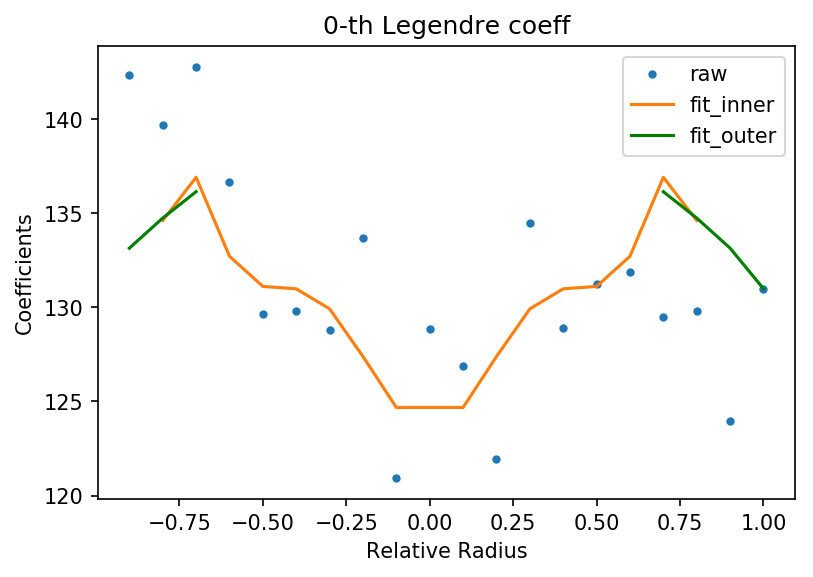

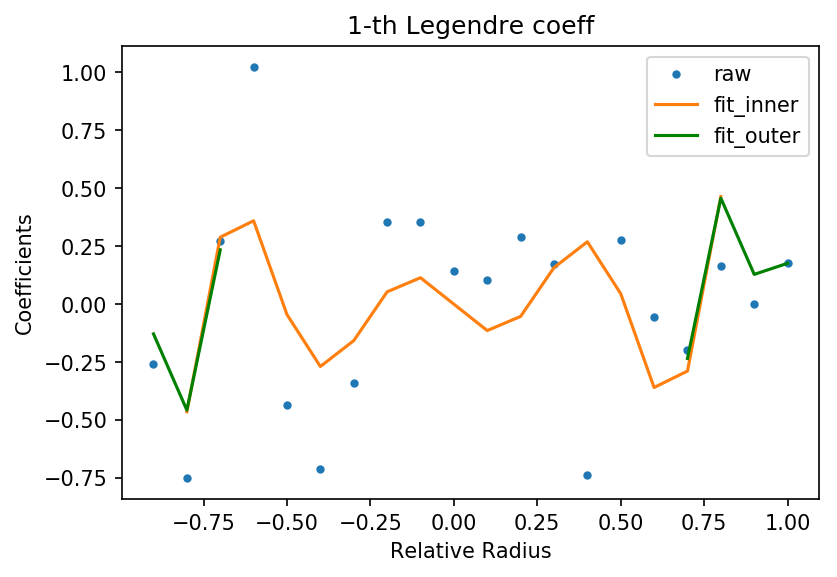

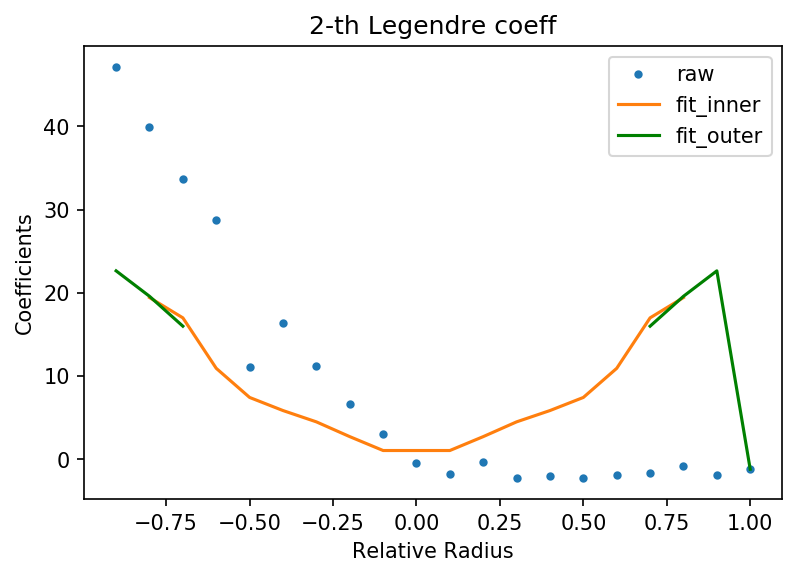

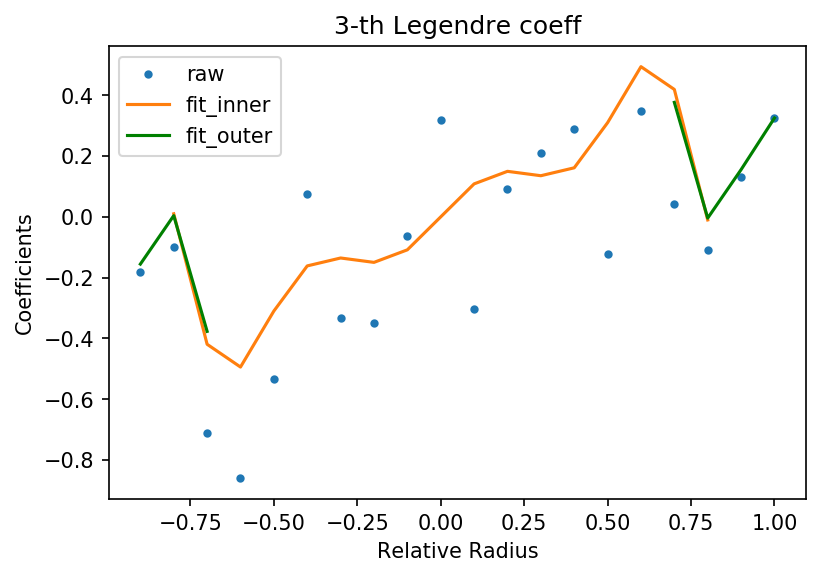

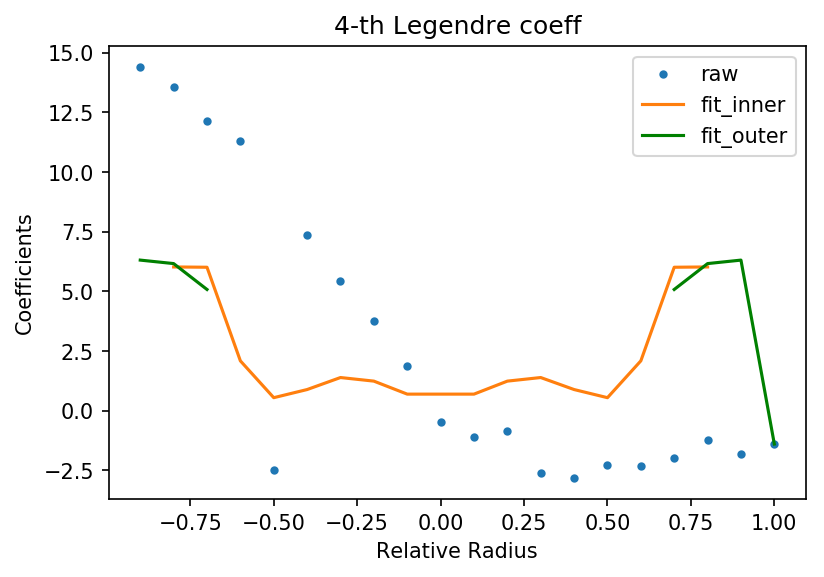

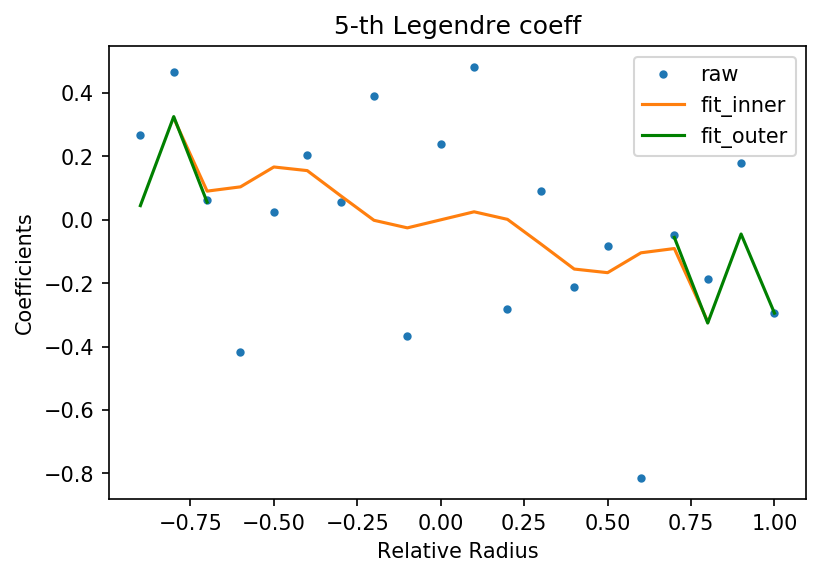

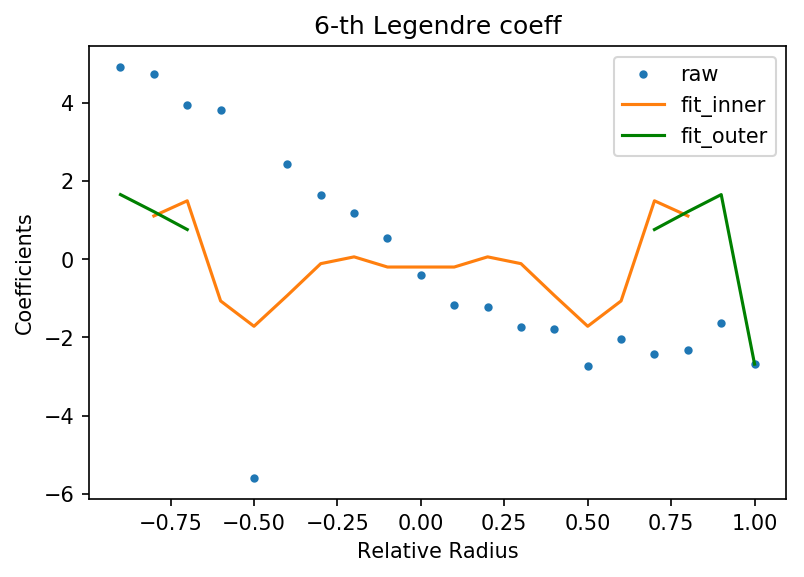

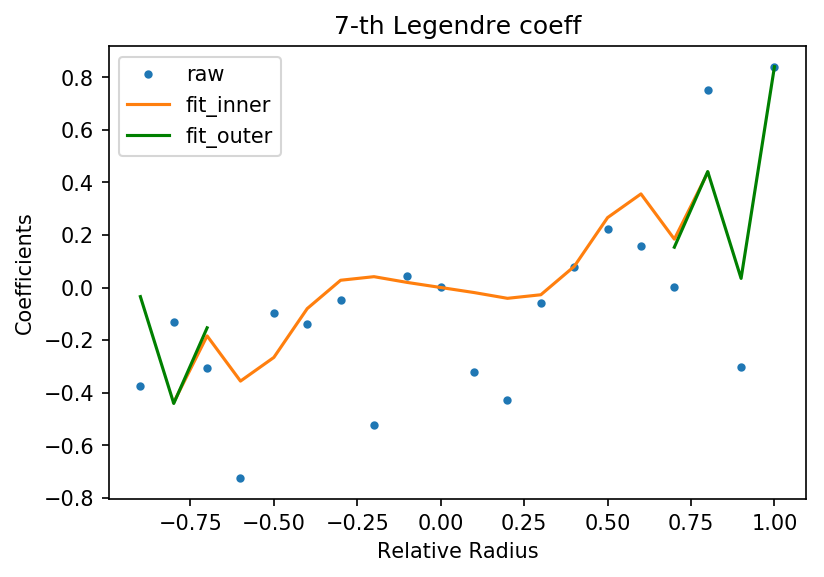

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


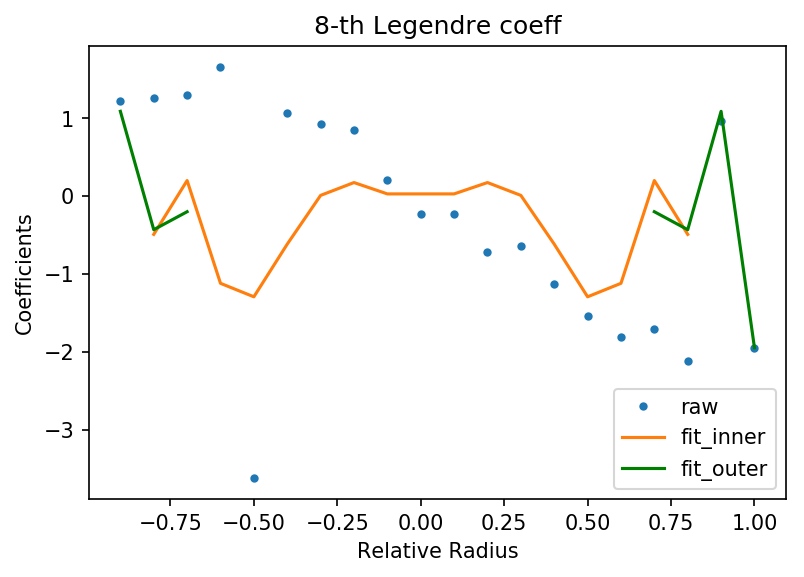

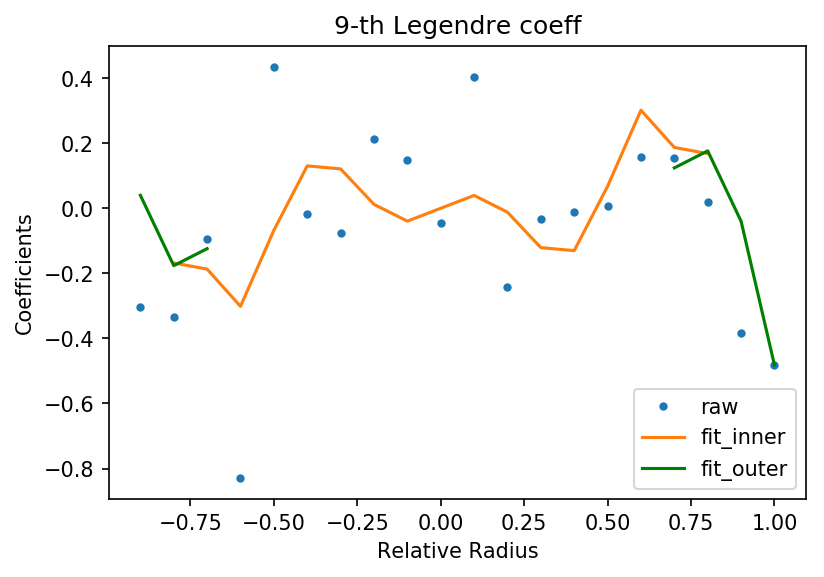

In [16]:
# ra = np.arange(+0.651, -0.65, -0.01)
for i in np.arange(np.size(coeff_time[:,0])):
    
    # segmented
    bd_1 = 0.80
    bd_2l = 0.50 
    bd_2r = 0.80
    bd_3 = 0.7
    
    fit_max = 5
    data = np.nan_to_num(coeff_time[i,:])
    #x = ra/0.65
    x = ra/10000

    index1 = (x<=bd_1) & (x>=-bd_1) & (x!=0)

    if(i%2==1):
        popt1, pcov = curve_fit(odd_func, x[index1], data[index1])
        output1 = odd_func(x[index1], *popt1)
    else:
        popt1, pcov = curve_fit(even_func, x[index1], data[index1])
        output1 = even_func(x[index1], *popt1)

    index2 = (np.abs(x)<=bd_2r) & (np.abs(x)>=bd_2l)
    if(i%2==1):
        popt2, pcov = curve_fit(odd_func, x[index2], data[index2])
        output2 = odd_func(x[index2], *popt2)
        #plt.plot(x[index1], odd_func(x[index1], *popt), 'r-')
    else:
        popt2, pcov = curve_fit(even_func, x[index2], data[index2])
        #plt.plot(x[index1], even_func(x[index1], *popt), 'r-')
        output2 = even_func(x[index2], *popt2)

    index3 = (x >= bd_3) | (x <= - bd_3)
    if(i%2==1):
        popt3, pcov = curve_fit(odd_func, x[index3], data[index3])
        output3 = odd_func(x[index3], *popt3)
    else:
        popt3, pcov = curve_fit(even_func, x[index3], data[index3])
        output3 = even_func(x[index3], *popt3)

    #x_total = np.hstack((x[index1],x[index2],x[index3]))
    #y_total = np.hstack((output1,output2,output3))
    #x_total = np.hstack((x[index1],x[index3]))
    #y_total = np.hstack((output1,output3))
    plt.figure(dpi=150)
    plt.plot(x, data,'.')
    #index = np.argsort(x_total)
    plt.plot(x[index1],output1)
    plt.plot(x[index3][x[index3]>0],output3[x[index3]>0], color='g')
    plt.plot(x[index3][x[index3]<0],output3[x[index3]<0], color='g') 
    #plt.plot(x_total[index],y_total[index])
    #plt.text(0,0.5,r'fit: z^1=%2.3f, z^3=%2.3f, z^5=%2.3f, z^7=%2.3f, z^9=%2.3f' % tuple(popt))
    plt.xlabel('Relative Radius')
    plt.ylabel('Coefficients')
    plt.title(str(i)+'-th Legendre coeff')
    plt.legend(['raw','fit_inner', 'fit_outer'])
    pdf.savefig()
    #plt.show()
    plt.close()

In [6]:
pdf.close()